training & result

In [2]:
from fastkaggle import *
import os
import timm
from fastai.vision.all import *
import gc
import os
from matplotlib import pyplot as plt
import cv2
set_seed(42)

In [3]:
comp = 'data'

path = setup_comp(comp, install='"fastcore>=1.4.5" "fastai>=2.7.1" "timm>=0.6.2.dev0"')

In [ ]:
path

Path('data')

In [ ]:
path.ls()

(#2) [Path('data/test'),Path('data/train')]

In [4]:
trn_path = path/'train'
files = get_image_files(trn_path)

print(trn_path)

data\train


In [22]:
models = {
    'vit_tiny_patch16_224': {
        (Resize(480, method='squish'), 224),
    },
}


In [23]:
def find_lr(arch, size, item=Resize(480, method='squish'), accum=1, finetune=True, epochs=15):
    dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.25, item_tfms=item,
        batch_tfms=aug_transforms(size=size, min_scale=0.75), bs=64)
    learn = vision_learner(dls, arch, metrics=[error_rate]).to_fp16()
    lr_valley, lr_slide = learn.lr_find(suggest_funcs=(valley, slide))
    
    return lr_valley, lr_slide


--- vit_tiny_patch16_224
224
Resize -- {'size': (480, 480), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


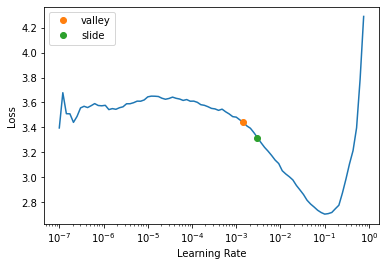

In [24]:
tta_res = []

for arch,details in models.items():
    for item,size in details:
        print('---',arch)
        print(size)
        print(item.name)
        
        lr_valley, lr_slide = find_lr(arch, size, item=item, finetune=True, accum=4)
    
        gc.collect()
        torch.cuda.empty_cache()

In [25]:
def plot_values(recorder, skip_start=5, with_valid=True):
        plt.plot(list(range(skip_start, len(recorder.values))), recorder.values[skip_start:], label='train')
        if with_valid:
            idx = (np.array(recorder.iters)<skip_start).sum()
            valid_col = recorder.metric_names.index('valid_accuracy') - 1 
            plt.plot(recorder.iters[idx:], L(recorder.values[idx:]).itemgot(valid_col), label='valid')
            plt.figure(1)
            plt.legend()

In [26]:
def train(arch, size, item=Resize(480, method='squish'), accum=1, finetune=True, epochs=15):
    dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.25, item_tfms=item,
                                       batch_tfms=aug_transforms(size=size, min_scale=0.75), bs=64)

    cbs = [EarlyStoppingCallback(min_delta=1e-4, patience=10), SaveModelCallback(monitor="valid_loss")]
    learn = vision_learner(dls, arch, metrics=[accuracy, error_rate], cbs=cbs).to_fp16()
    learn.recorder.train_metrics = True
    tst_files = get_image_files(path/'test').sorted()
    if finetune:
        learn.fine_tune(epochs, 0.01)
        learn.recorder.plot_loss()
        learn.recorder.plot_values()
        learn.tta(dl=dls.test_dl(tst_files))
    else:
        learn.unfreeze()
        learn.fit_one_cycle(epochs, 0.01)
        learn.recorder.plot_loss()
        learn.recorder.plot_values()

    return learn, dls


In [27]:
torch.cuda.empty_cache()

--- vit_tiny_patch16_224
224
Resize -- {'size': (480, 480), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,train_accuracy,train_error_rate,valid_loss,valid_accuracy,valid_error_rate,time
0,1.786523,0.397068,0.602932,0.930658,0.693750,0.306250,04:17


Better model found at epoch 0 with valid_loss value: 0.9306581616401672.


epoch,train_loss,train_accuracy,train_error_rate,valid_loss,valid_accuracy,valid_error_rate,time
0,1.031593,0.645457,0.354543,0.673705,0.778365,0.221635,04:58
1,0.891778,0.707152,0.292848,0.574945,0.809615,0.190385,04:59
2,0.781079,0.740496,0.259504,0.505530,0.830769,0.169231,05:01
3,0.662072,0.778028,0.221972,0.429868,0.853846,0.146154,04:57
4,0.573699,0.807345,0.192655,0.389357,0.862019,0.137981,04:55
5,0.487347,0.842461,0.157539,0.337194,0.883173,0.116827,04:55
6,0.458270,0.845039,0.154961,0.306715,0.905288,0.094712,04:55
7,0.403952,0.862919,0.137081,0.302736,0.900000,0.100000,04:54
8,0.385005,0.879349,0.120651,0.286640,0.911538,0.088462,04:55
9,0.333759,0.888692,0.111308,0.294898,0.912981,0.087019,05:01


Better model found at epoch 0 with valid_loss value: 0.6737046241760254.
Better model found at epoch 1 with valid_loss value: 0.5749454498291016.
Better model found at epoch 2 with valid_loss value: 0.505529522895813.
Better model found at epoch 3 with valid_loss value: 0.42986753582954407.
Better model found at epoch 4 with valid_loss value: 0.3893570601940155.
Better model found at epoch 5 with valid_loss value: 0.3371937572956085.
Better model found at epoch 6 with valid_loss value: 0.30671510100364685.
Better model found at epoch 7 with valid_loss value: 0.3027356266975403.
Better model found at epoch 8 with valid_loss value: 0.2866401970386505.
Better model found at epoch 10 with valid_loss value: 0.27320539951324463.
Better model found at epoch 11 with valid_loss value: 0.23482109606266022.
Better model found at epoch 12 with valid_loss value: 0.2325877845287323.
Better model found at epoch 13 with valid_loss value: 0.1954869031906128.
Better model found at epoch 15 with valid_lo

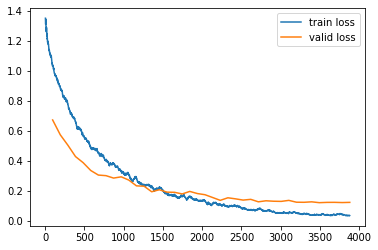

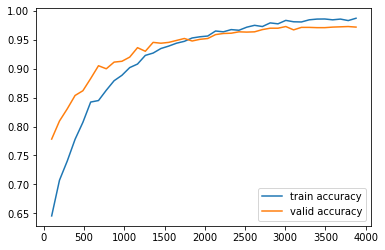

In [28]:
for arch,details in models.items():
    for item,size in details:
        print('---',arch)
        print(size)
        print(item.name)
        
        learn, dls = train(arch, size, item=item, finetune=True, accum=4, epochs=40)
        learn.save(arch+"_no_grad_accum")
        learn.export("models/"+arch+"_no_grad_accum.pkl")

        
        gc.collect()
        torch.cuda.empty_cache()

In [5]:
models = {
    'vit_tiny_patch16_224': {
        (Resize(480, method='squish'), 224),
    },
}

def train(arch, size, item=Resize(480, method='squish'), accum=1, finetune=True):
    dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.25, item_tfms=item,
        batch_tfms=aug_transforms(size=size, min_scale=0.75), bs=32//accum)
    cbs = GradientAccumulation(64) if accum else []
    learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()

    return learn, dls

for arch,details in models.items():
    for item,size in details:
        print('---',arch)
        print(size)
        print(item.name)
        
        learn, dls = train(arch, size, item=item, finetune=True, accum=4)
    
        gc.collect()
        torch.cuda.empty_cache()


--- vit_tiny_patch16_224
224
Resize -- {'size': (480, 480), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [6]:
from fastai.text.all import * 
learner= learn.load("vit_tiny_patch16_224_no_grad_accum")

In [11]:
interpret = ClassificationInterpretation.from_learner(learner)

In [33]:
interpret.print_classification_report()

                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.97      0.94      0.95        97
   bacterial_leaf_streak       0.98      0.94      0.96        67
bacterial_panicle_blight       0.97      0.94      0.95        62
                   blast       0.96      0.99      0.97       340
              brown_spot       0.94      0.97      0.96       190
              dead_heart       1.00      0.99      1.00       318
            downy_mildew       0.93      0.88      0.90       129
                   hispa       0.97      0.98      0.97       304
                  normal       0.98      0.99      0.99       349
                  tungro       0.99      0.97      0.98       224

                accuracy                           0.97      2080
               macro avg       0.97      0.96      0.96      2080
            weighted avg       0.97      0.97      0.97      2080



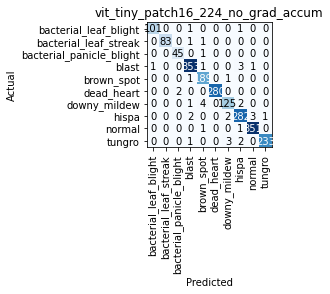

In [16]:
interpret.plot_confusion_matrix(title="vit_tiny_patch16_224_no_grad_accum")

In [7]:
for arch,details in models.items():
    for item,size in details:        
        dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.25, item_tfms=item,
                batch_tfms=aug_transforms(size=size, min_scale=0.75), bs=32//4)
        tst_files = get_image_files(path/'test').sorted()
        tst_dl = dls.test_dl(tst_files, with_labels=True, num_workers=0)
        tst_dl

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [14]:
acc = accuracy(*learner.get_preds(dl=tst_dl))
print('The accuracy is {0} %.'.format(acc))

The accuracy is 0.8848368525505066 %.


In [ ]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']